## Prerequisites

In [1]:
import os
from os import chdir

import pandas as pd 
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from scipy.sparse import load_npz
from scipy.sparse import save_npz

from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

from scipy.sparse import spdiags


chdir(
    r'C:\Users\laplace-transform\AppData\Local\Programs\Python\Python37\notebooks\2020-knu-ai-master\jigsaw-toxic-comment-classification-challenge'
)

### Note! Some of these models support only multiclass classification, please, while selecting your dataset,  
### be sure that for algorithms which does not support multilabel classification you use only examples with only one label. 
### Examples without a label in any of the provided categories are clean messages, without any toxicity.

In [2]:
df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

In [3]:
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"['explanation', 'edits', 'made', 'username', '..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[""d'aww"", 'match', 'background', 'colour', ""'m..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"['hey', 'man', ""'m"", 'really', 'trying', 'edit..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"['``', 'ca', ""n't"", 'make', 'real', 'suggestio..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"['sir', 'hero', 'chance', 'remember', 'page', ..."


In [4]:
df.shape

(159571, 10)

### As one of the methods to make the training simpier, use only examples, assigned to any category vs clean examples.  
For example:  
- Select only messages with obscene label == 1  
- Select all of the "clean" messages  
Implement a model which can perform a binary classification  - to understand whether your message is obscene or not.   

##### If you want to perform a multilabel classification, please understand the difference between multilabel and multiclass classification and be sure that you are solving the correct task - choose only algorithms applicable for solving this type of problem.

#### To work with multiclass task:  
You only need to select messages which have only one label assigned: message cannot be assigned to 2 or more categories.  

#### To work with multilabel task: 
You can work with the whole dataset - some of your messages have only 1 label, some more than 1. 

## Text vectorization

Previously we worked only with words vectorization. But we need to have a vector for each text, not only words from it. 

Before starting a text vectorization, please, make sure you are working with clean data - use the dataset created on the previous day. Cleaned from punctuation, stop words, lemmatized or stemmed, etc. 

In [5]:
from string import punctuation

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

In [6]:
def preprocess_text(tokenizer, lemmatizer, stop_words, punctuation, text): 
    tokens = tokenizer(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in lemmas if token not in stop_words and token not in punctuation]

df['cleaned'] = df.comment_text.apply(lambda x: preprocess_text(word_tokenize, lemmatizer, stop_words, punctuation, x))

In [7]:
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore,..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[d'aww, match, background, colour, 'm, seeming..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[hey, man, 'm, really, trying, edit, war, 's, ..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"[``, ca, n't, make, real, suggestion, improvem..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[sir, hero, chance, remember, page, 's]"


In [8]:
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

In [9]:
vocab = set(flat_nested(df.cleaned.tolist()))

In [10]:
len(vocab)

249531

As we see, probably you vocabulary is too large.  
Let's try to make it smaller.  
For example, let's get rig of words, which has counts in our dataset less than some threshold.

In [11]:
from collections import Counter, defaultdict 

cnt_vocab = Counter(flat_nested(df.cleaned.tolist()))

In [12]:
cnt_vocab.most_common(10)

[("''", 241319),
 ('``', 156982),
 ('article', 73264),
 ("'s", 66766),
 ("n't", 57144),
 ('wa', 56590),
 ('page', 56239),
 ('wikipedia', 45413),
 ('talk', 35356),
 ('ha', 31896)]

You can clean words which are shorter that particular length and occur less than N times. 

In [13]:
threshold_count = 10
threshold_len = 4 
cleaned_vocab = [token for token, count in cnt_vocab.items() if count > threshold_count and len(token) > threshold_len]

In [14]:
len(cleaned_vocab)

18705

Much better!  
Let's try to vectorize the text summing one-hot vectors for each word. 

In [15]:
vocabulary = defaultdict()

for i, token in enumerate(cleaned_vocab): 
    empty_vec = np.zeros(len(cleaned_vocab))
    empty_vec[i] = 1 
    vocabulary[token] = empty_vec

In [16]:
vocabulary['hardcore']

array([0., 0., 0., ..., 0., 0., 0.])

Rigth now we have vectors for words (words are one-hot vectorized)  
Let's try to create vectors for texts: 

In [17]:
sample_text = df.cleaned[10]
print(sample_text)

['``', 'fair', 'use', 'rationale', 'image', 'wonju.jpg', 'thanks', 'uploading', 'image', 'wonju.jpg', 'notice', 'image', 'page', 'specifies', 'image', 'used', 'fair', 'use', 'explanation', 'rationale', 'use', 'wikipedia', 'article', 'constitutes', 'fair', 'use', 'addition', 'boilerplate', 'fair', 'use', 'template', 'must', 'also', 'write', 'image', 'description', 'page', 'specific', 'explanation', 'rationale', 'using', 'image', 'article', 'consistent', 'fair', 'use', 'please', 'go', 'image', 'description', 'page', 'edit', 'include', 'fair', 'use', 'rationale', 'uploaded', 'fair', 'use', 'medium', 'consider', 'checking', 'specified', 'fair', 'use', 'rationale', 'page', 'find', 'list', "'image", 'page', 'edited', 'clicking', '``', "''", 'contribution', "''", "''", 'link', 'located', 'top', 'wikipedia', 'page', 'logged', 'selecting', '``', "''", 'image', "''", "''", 'dropdown', 'box', 'note', 'fair', 'use', 'image', 'uploaded', '4', 'may', '2006', 'lacking', 'explanation', 'deleted', 'one

### One-hot vectorization and count vectorization

In [18]:
sample_vector = np.zeros(len(cleaned_vocab))

for token in sample_text: 
    try: 
        sample_vector += vocabulary[token]
    except KeyError: 

        continue

In [19]:
sample_vector

array([3., 0., 0., ..., 0., 0., 0.])

Right now we have count vectorization for our text.   
Use this pipeline to create vectors for all of the texts. Save them into np.array. i-th raw in np.array is a vector which represents i-th text from the dataframe.  

In [20]:
def vocabulary_interact_vect(sample_text, vect_vocabulary):
    text_vector = np.zeros(len(vect_vocabulary))
    for token in sample_text:
        try: 
            text_vector += vect_vocabulary[token]
        except KeyError: 
            continue
    return text_vector


# because we're going to use matrix interpret on train/test data
def matrix_of_features_sparse(corpus, vect_vocabulary):
    corpus_len, vocabl_len = len(corpus), len(vect_vocabulary)
    feature_matr = lil_matrix((corpus_len, vocabl_len))
    
    for j in range(corpus_len):
        feature_matr[j] = lil_matrix(
            vocabulary_interact_vect(corpus[j], vect_vocabulary)
        )
        
    return feature_matr

In [21]:
cp = [
    ['this', 'is', 'the', 'first', 'document'],
    ['this', 'document', 'is', 'the', 'second', 'document'],
    ['and', 'this', 'is', 'the', 'third', 'one'],
    ['is', 'this', 'the', 'first', 'document']
]
i = matrix_of_features_sparse(cp, vocabulary).toarray()[
    :,list(vocabulary.keys()).index('document')]
tr = CountVectorizer(vocabulary = cleaned_vocab).fit([' '.join(e) for e in cp])
j = tr.transform([' '.join(e) for e in cp]).toarray()[
    :,list(vocabulary.keys()).index('document')]
print(i, j)
print(matrix_of_features_sparse(cp, vocabulary), tr.transform([' '.join(e) for e in cp]), sep='\n\n')

[1. 2. 0. 1.] [1 2 0 1]
  (0, 46)	1.0
  (0, 2531)	1.0
  (1, 825)	1.0
  (1, 2531)	2.0
  (2, 226)	1.0
  (3, 46)	1.0
  (3, 2531)	1.0

  (0, 46)	1
  (0, 2531)	1
  (1, 825)	1
  (1, 2531)	2
  (2, 226)	1
  (3, 46)	1
  (3, 2531)	1


In [22]:
N = len(cleaned_vocab)

text_vectorized = matrix_of_features_sparse(
    corpus = pd.Series([df.cleaned[10]]), vect_vocabulary = vocabulary
)

text_vectorized.toarray()

array([[3., 0., 0., ..., 0., 0., 0.]])

In [23]:
util_load = True

path0 = os.getcwd() + os.sep + 'document_term_matrix.npz'

if util_load:
    text_vectorized = load_npz(path0)
else:
    text_vectorized = matrix_of_features_sparse(
        corpus = df.cleaned, vocabulary_len = N, vect_vocabulary = vocabulary
    )

In [24]:
text_vectorized

<159571x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 2717363 stored elements in Compressed Sparse Row format>

In [25]:
util_save = True

if util_save:
    save_npz(path0, text_vectorized)
    
util_del = True

if util_del:
    del text_vectorized

### The next step is to train any classification model on top of the received vectors and report the quality. 

Please, select any of the proposed pipelines for performing a text classification task. (Binary, multiclass or multilabel).  

The main task to calculate our models performance is to create a training and test sets. When you selected a texts for your task, please, use https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html to have at least two sets - train and test.  

Train examples you will use to train your model on and test examples to evaluate your model - to understand how your model works on the unseen data. 

### Train-test split 

In [26]:
### Your code here, splitting your dataset into train and test parts.

# This time i'm going to handle binary classification task
# First of all, I'll divide df into two separate groups:
# - non-toxic data
# - insult labelled data

df_categories = [
    'identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic'
]

crucial_data = df[[df_categories[1], 'cleaned']]

df_non_toxic = crucial_data[~df[df_categories].any(axis = 'columns')]
df_insulting = crucial_data[df.insult != 0]

df_combined = df_non_toxic.append(df_insulting).reset_index(drop = True)
df_combined.columns = ['label', 'texts']

print(
    df_combined.head(),
    df_combined.tail(),
    sep = '\n\n'
)

   label                                              texts
0      0  [explanation, edits, made, username, hardcore,...
1      0  [d'aww, match, background, colour, 'm, seeming...
2      0  [hey, man, 'm, really, trying, edit, war, 's, ...
3      0  [``, ca, n't, make, real, suggestion, improvem...
4      0            [sir, hero, chance, remember, page, 's]

        label                                              texts
151218      1  [``, previous, conversation, fucking, shit, ea...
151219      1                        [mischievious, pubic, hair]
151220      1  [absurd, edits, absurd, edits, great, white, s...
151221      1  [``, hey, listen, n't, ever, delete, edits, ev...
151222      1  ['m, going, keep, posting, stuff, u, deleted, ...


In [176]:
from sklearn.model_selection import train_test_split

custom_test_size = 0.25

X = df_combined['texts']
Y = df_combined['label']

In [222]:
M = 40000
XY_sample = pd.concat([X, Y], axis=1).sample(M)
XY_sample

,texts,label
120335,"[``, issue, addressed, decided, pas, article, ...",0
42214,"[hi, neuromancer, never, get, anywhere, like, ...",0
81276,"[``, n't, know, logic, policy, hopefully, fæ, ...",0
148981,"[fucking, serious, hume, read, go, fuck, ignor...",1
61690,"['m, really, sorry, take, long, problem, worki...",0
...,...,...
141879,"[thanks, reverting, vandalism, james, weldon, ...",0
70619,"[recent, edit, triple, h, edit, wa, vandalism,...",0
35497,"[opinion, hello, soon, retire, wikipedia, woul...",0
19647,"[congrats, first, headley, experience, fainite...",0


In [223]:
#XY_sample[XY_sample['label'] == 1]

In [224]:
# making train and test sets for future model
X_train, X_test, Y_train, Y_test = train_test_split(
    XY_sample['texts'], XY_sample['label'], test_size = custom_test_size
)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [225]:
# Train set
X_train.head()

0    [clear, n't, ever, read, book, irish, history,...
1    [``, prodding, tiger, please, sir, n't, mean, ...
2    [father, tanner, thank, bringing, sanity, arti...
3    [discussion, two, year, old, believe, record, ...
4    [``, request, comment, shed, light, issue, ``,...
Name: texts, dtype: object

In [226]:
# Test set
X_test.head()

0    [apparently, write, get, permission, miss, gre...
1    [listen, buddy, even, europe, aryan, come, afg...
2                              [affiliation, scotland]
3    [``, block, even, outrageous, illegitimate, fi...
4    [please, restore, stop, removing, comment, eff...
Name: texts, dtype: object

### TF-IDF score 

#### Please, review again this article or read it if you have not done it before. 

https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7

#### Implement calculating a tf-idf score for each of the words from your vocabulary. 

The main goal of this task is to create a dictionary - keys of the dictionary would be tokens and values would be corresponding tf-idf score of the token.

#### Calculate it MANUALLY and compare the received scores for words with the sklearn implementation:  

#### Tip: 

##### TF = (Number of time the word occurs in the current text) / (Total number of words in the current text)  

##### IDF = (Total number of documents / Number of documents with word t in it)

##### TF-IDF = TF*IDF 

When you calculated a tf-idf score for each of the words in your vocabulary - revectorize the texts.  
Instead of using number of occurences of the i-th word in the i-th cell of the text vector, use it's tf-idf score.   

Revectorize the documents, save vectors into np.array. 

In [211]:
### Your code here for obtaining a tf-idf vectorized documents. 

# Like mentioned above, we're going to define 
# the tf-idf vectorization method manually.

def TF_IDF_sparse_smooth(document_term_matr: csr_matrix): # ispired by numpy potential and sklearn source code
    result_matr = csr_matrix(document_term_matr, dtype=np.float64, copy=True)
    
    corpus_len, vocab_len = result_matr.shape
    docmntfreq = np.bincount(result_matr.indices, minlength=result_matr.shape[1])    
    invdocfreq = np.log(float(corpus_len + 1)/(docmntfreq + 1)) + 1
    
    idf_matrix = spdiags(invdocfreq, diags=0, m=vocab_len, n=vocab_len)
    result_matr = result_matr * idf_matrix
    print(np.ravel(idf_matrix.sum(axis=0))) # idf for each word, ravel <-> flatten
    
    return result_matr # returns tf-idf matrix

In [227]:
# no-sklearn implementation:
# code for vocabulary_interact_sparse use

path1 = os.getcwd() + os.sep + 'x_train_tf_idf_sparse.npz'

util_load = False

if util_load:
    X_train_count_matrix = load_npz(path1)
else:
    X_train_count_matrix = matrix_of_features_sparse(X_train, vocabulary)

X_train_count_matrix

<30000x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 523445 stored elements in List of Lists format>

In [228]:
# code for TF_IDF_sparse_smooth use
# considering that manual implementation of tf-idf is slow, we'll show the results for shortened vocabulary

X_train_tf_idf_manual = TF_IDF_sparse_smooth(X_train_count_matrix)
X_train_tf_idf_manual

[ 5.40908864  4.05057384  5.80365446 ... 11.30898599 11.30898599
 11.30898599]


<30000x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 523445 stored elements in Compressed Sparse Row format>

In [229]:
pipeline_simplified = Pipeline(
    [
        ('cnt-matr', CountVectorizer(vocabulary = cleaned_vocab)),
        ('tf-idf-sparse-matr', TfidfTransformer(norm = None))
    ]
).fit(X_train.str.join(' '))

X_train_tf_idf_simpl = pipeline_simplified.transform(X_train.str.join(' '))
X_train_tf_idf_simpl # differs from matrix above, actually. 
# because of the difference between manually-written countvectorization and the sklearn one. idk why right now, fix later

<30000x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 528660 stored elements in Compressed Sparse Row format>

In [230]:
cnt1 = CountVectorizer(vocabulary = cleaned_vocab).fit(X_train.str.join(' '))

X_train_cnt_vect = cnt1.transform(X_train.str.join(' '))

In [231]:
X_train_cnt_vect

<30000x18705 sparse matrix of type '<class 'numpy.int64'>'
	with 528660 stored elements in Compressed Sparse Row format>

In [232]:
X_train_count_matrix # see comment above

<30000x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 523445 stored elements in List of Lists format>

In [233]:
trans_wo_norm = TfidfTransformer(norm = None)
X_train_cnt_to_tf_idf = trans_wo_norm.fit_transform(X_train_count_matrix)
X_train_cnt_to_tf_idf

<30000x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 523445 stored elements in Compressed Sparse Row format>

In [234]:
trans_wo_norm.idf_

array([ 5.40908864,  4.05057384,  5.80365446, ..., 11.30898599,
       11.30898599, 11.30898599])

In [235]:
(X_train_cnt_to_tf_idf != X_train_tf_idf_manual).nnz == 0 
# equal; calc different elems in sparse matrices if more efficient than calc equal ones
# .nnz <-> number of non-zero elems; in this case: number of different elements in matrices

True

In [236]:
if util_save:
    
    save_npz(path1, X_train_count_matrix)
    
if util_del:
    
    del X_train_count_matrix

In [237]:
# sklearn implementation

X_train_concat = X_train.str.join(' ')
X_test_concat = X_test.str.join(' ')

pipeline_global = Pipeline(
    [
        ('cnt-matr', CountVectorizer(vocabulary = cleaned_vocab)),
        ('tf-idf-sparse-matr', TfidfTransformer())
    ]
)

X_train_tf_idf_sparse = pipeline_global.fit_transform(X_train_concat)
X_test_tf_idf_sparse = pipeline_global.transform(X_test_concat)

In [238]:
X_train_tf_idf_sparse

<30000x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 528660 stored elements in Compressed Sparse Row format>

### Training the model 

As it was said before, select any of the text classification models for the selected task and train the model. 

When the model is trained, you need to evaluate it somehow. 

Read about True positive, False positive, False negative and True negative counts and how to calculate them:   

https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative 

##### Calculate TP, FP, FN and TN on the test set for your model to measure its performance. 


In [239]:
linear_classifier = LogisticRegression(
    random_state = 0                     # <=> seed equiv.
).fit(X_train_tf_idf_sparse, Y_train)

In [240]:
#linear_classifier.score(X_train_tf_idf_sparse, Y)

Y_prediction = linear_classifier.predict(X_test_tf_idf_sparse)

print(Y_prediction.shape)
print(Y_test.shape)

(10000,)
(10000,)


In [241]:
# assuming that we have only 0 or 1 in Y_test/Y_pred

def TP_FP_FN_TN(
    y_test,       # validated labels
    y_pred):      # predicted labels
    TN = lambda y_test, y_pred: np.sum([(y_test==y_pred) & y_test]) 
    TP = lambda y_test, y_pred: np.sum([(y_test==y_pred) & ~y_test])
    
    FN = lambda y_test, y_pred: np.sum([(y_test!=y_pred) & y_test])
    FP = lambda y_test, y_pred: np.sum([~((y_test==y_pred) | y_test)])
    
    return np.array(list(map(lambda f: f(y_test, y_pred),[TP, FP, FN, TN]))).reshape((2, 2))


outcomes = TP_FP_FN_TN(Y_test, Y_prediction)
print(Y_prediction.shape == np.sum(outcomes))
outcomes

[ True]


array([[9467,    6],
       [ 321,  206]])

#### The next step is to calculate  Precision, Recall, F1 and F2 score 

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

In [242]:
def model_report(
    y_test,       # validated labels
    y_pred):      # predicted labels
    
    confusion_matr_t = np.transpose(TP_FP_FN_TN(y_test, y_pred))
    
    # [TP FP]^T
    # [FN TN]
    
    PRE = confusion_matr_t[0,0]/np.sum(confusion_matr_t[0,:])
    REC = confusion_matr_t[0,0]/np.sum(confusion_matr_t[:,0])
    ACC = np.trace(confusion_matr_t) / np.sum(confusion_matr_t)
    
    Fbeta = lambda beta: (
        (1 + beta ** 2) * (PRE * REC) / (((beta ** 2) * PRE) + REC)
    )
    
    print(confusion_matr_t)
    return {
        'PRE': PRE,
        'REC': REC,
        'F1S': Fbeta(1),
        'F2S': Fbeta(2),
        'ACC': ACC
    }
    

model_report(Y_test, Y_prediction)

[[9467  321]
 [   6  206]]


{'PRE': 0.9672047404985696,
 'REC': 0.9993666209226222,
 'F1S': 0.9830226883339391,
 'F2S': 0.9927642617449663,
 'ACC': 0.9673}

In [243]:
# using sklearn package
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_prediction)

array([[9467,    6],
       [ 321,  206]], dtype=int64)

In [244]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_prediction))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9473
           1       0.97      0.39      0.56       527

    accuracy                           0.97     10000
   macro avg       0.97      0.70      0.77     10000
weighted avg       0.97      0.97      0.96     10000



In [245]:
from sklearn.metrics import accuracy_score
A0 = accuracy_score(Y_test, Y_prediction)
A0

0.9673

Calculate these metrics for the vectorization created using count vectorizing and for tf-idf vectorization.  
Compare them. 

In [246]:
# calculation based on count matrices

X_train_q, X_test_q, Y_train_q, Y_test_q = train_test_split(
    XY_sample['texts'], XY_sample['label'], test_size = custom_test_size
)

X_train_q = X_train_q.reset_index(drop = True)
X_test_q = X_test_q.reset_index(drop = True)

Y_train_q = Y_train_q.reset_index(drop = True)
Y_test_q = Y_test_q.reset_index(drop = True)

X_train_concat_q =  X_train_q.str.join(' ')
X_test_concat_q = X_test_q.str.join(' ')

cnt_vect_model = CountVectorizer(vocabulary = cleaned_vocab)

X_train_q_sparse = cnt_vect_model.fit_transform(X_train_concat_q)
X_test_q_sparse = cnt_vect_model.transform(X_test_concat_q)

In [247]:
X_train_q_sparse

<30000x18705 sparse matrix of type '<class 'numpy.int64'>'
	with 525225 stored elements in Compressed Sparse Row format>

In [250]:
linear_classifier_q = LogisticRegression(
    random_state = 0
).fit(X_train_q_sparse, Y_train_q)

In [251]:
Y_prediction_q_lr = linear_classifier_q.predict(X_test_q_sparse)
print(classification_report(Y_test_q, Y_prediction_q_lr))
print(confusion_matrix(Y_test_q, Y_prediction_q_lr))
print(accuracy_score(Y_test_q, Y_prediction_q_lr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9481
           1       0.92      0.54      0.68       519

    accuracy                           0.97     10000
   macro avg       0.95      0.77      0.84     10000
weighted avg       0.97      0.97      0.97     10000

[[9458   23]
 [ 237  282]]
0.974


In [56]:
# we're going to the forest!
# https://towardsdatascience.com/understanding-random-forest-58381e0602d2
# https://shorturl.at/fFOP4
# also, https://scikit-learn.org/stable/modules/tree.html#tree

In [252]:
rand_forest_model_q = RandomForestClassifier().fit(
    X_train_q_sparse, Y_train_q
)

In [253]:
Y_prediction_q = rand_forest_model_q.predict(X_test_q_sparse)

In [254]:
outcomes_q = confusion_matrix(Y_test_q, Y_prediction_q)
outcomes_q

array([[9414,   67],
       [ 214,  305]], dtype=int64)

In [255]:
AQ = accuracy_score(Y_test_q, Y_prediction_q)
AQ

0.9719

In [256]:
print(classification_report(Y_test_q, Y_prediction_q))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9481
           1       0.82      0.59      0.68       519

    accuracy                           0.97     10000
   macro avg       0.90      0.79      0.83     10000
weighted avg       0.97      0.97      0.97     10000



In [257]:
rand_forest_model_f = RandomForestClassifier().fit(
    X_train_tf_idf_sparse, Y_train
)

In [258]:
Y_prediction_f = rand_forest_model_f.predict(X_test_tf_idf_sparse)

In [259]:
outcomes_f = confusion_matrix(Y_test, Y_prediction_f)
outcomes_f

array([[9431,   42],
       [ 230,  297]], dtype=int64)

In [260]:
AF = accuracy_score(Y_test, Y_prediction_f)
AF

0.9728

In [261]:
print(classification_report(Y_test, Y_prediction_f))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9473
           1       0.88      0.56      0.69       527

    accuracy                           0.97     10000
   macro avg       0.93      0.78      0.84     10000
weighted avg       0.97      0.97      0.97     10000



In [262]:
AQ < AF

True

In [264]:
A0 < AF 
# rf perfoms better, but on bigger amounts of data
# this time, we can see that cnt-vect + regression is good for smaller amounts

True

In [265]:
from joblib import dump
#from joblib import load

dump(linear_classifier, 'rforest_tfidf_cls.joblib')

['rforest_tfidf_cls.joblib']

### Conclusions and improvements 

For all of the vectorization pipelines we used all of the words, which were available in our dictionary, as experiment try to use the most meaningful words - select them using TF-IDF score. (for example for each text you can select not more than 10 words for vectorization, or less). 

Compare this approach with the first and second ones. Did your model improve? 



In [266]:
# Another code for task above

X_full_concat = df.cleaned.str.join(' ')

pipeline_full = pipeline_global.fit(X_full_concat)

X_full_concat_tf_idf = pipeline_full.transform(X_full_concat)

In [267]:
X_full_concat_tf_idf

<159571x18705 sparse matrix of type '<class 'numpy.float64'>'
	with 2745109 stored elements in Compressed Sparse Row format>

In [268]:
X_full_concat_tf_idf[0].nonzero()[1][::-1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [269]:
to_filter = np.zeros(len(cleaned_vocab))

M = len(X_full_concat)

for j in range(M):
    
    to_add = np.zeros(len(cleaned_vocab))
    
    idx_non_zero = X_full_concat_tf_idf[j].nonzero()[1][::-1]
    
    np.put(to_add, idx_non_zero, np.ones(len(idx_non_zero)))
    
    to_filter += to_add

In [270]:
print(len(X_full_concat_tf_idf.nonzero()[0]), sum(to_filter))

2745109 2745109.0


In [271]:
len(to_filter[to_filter != 0])

17409

In [272]:
new_vocabulary = np.array(cleaned_vocab)[np.where(to_filter != 0)]
new_vocabulary

array(['explanation', 'edits', 'username', ..., 'sampi', 'ragan', 'garan'],
      dtype='<U173')

In [273]:
X_train_u, X_test_u, Y_train_u, Y_test_u = train_test_split(
    XY_sample['texts'], XY_sample['label'], test_size = custom_test_size
)

X_train_u = X_train_u.reset_index(drop = True)
X_test_u = X_test_u.reset_index(drop = True)

Y_train_u = Y_train_u.reset_index(drop = True)
Y_test_u = Y_test_u.reset_index(drop = True)

In [274]:
X_train_concat_u =  X_train_u.str.join(' ')
X_test_concat_u = X_test_u.str.join(' ')

X_train_tf_idf_sparse_upd = pipeline_global.fit_transform(X_train_concat_u)
X_test_tf_idf_sparse_upd = pipeline_global.transform(X_test_concat_u)

In [275]:
linear_classifier.fit(X_train_tf_idf_sparse_upd, Y_train_u)

Y_prediction_upd = linear_classifier.predict(X_test_tf_idf_sparse)

In [276]:
conf = confusion_matrix(Y_test, Y_prediction_upd)
conf

array([[9470,    3],
       [ 310,  217]], dtype=int64)

In [277]:
A1 = accuracy_score(Y_test_u, Y_prediction_upd)
A1

0.9304

In [278]:
print(classification_report(Y_test_u, Y_prediction_upd))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9506
           1       0.04      0.02      0.03       494

    accuracy                           0.93     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.91      0.93      0.92     10000



In [279]:
A1 > A0 # See, because of sparsity. Details below

False

In [280]:
dump(linear_classifier, 'logistic_cls.joblib')

['logistic_cls.joblib']

Такий підхід досить погано вплинув на модель. У даному випадку, різкий спад показників пояснюється двома факторами - сильна розрідженість матриць та малі обсяги нового словника. Перше випливає з другого. Дані суттєво скорочуються, їх недоречно застосовувати для тренування моделі. Для словника беруться лише ті, у яких значення tf-idf достатньо велике. Отже, можливо те, що ті слова, які мають відносно невеликі показники tf-idf, однак відіграють значну роль у визначенні семантики тексту, будуть відкинуті.

### Additionally, visualisations 

For now you have a vector for each word from your vocabulary. 
You have vectors with lenght > 18000, so the dimension of your space is more than 18000 - it's impossible to visualise it in 2d space. 

So try to research and look for algorithms which perform dimensionality reduction. (t-SNE, PCA) 
Try to visualise obtained vectors in a vectorspace, only subset from the vocabulary, don't plot all of the words. (100) 

Probably on this step you will realise how this type of vectorization using these techniques is not the best way to vectorize words. 

Please, analyse the obtained results and explain why visualisation looks like this. 

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [86]:
hot_vectors = np.array(list(vocabulary.values()))

pca_model = PCA(n_components = 3)
pca_model.fit(hot_vectors)

hot_vectors_transformed = pca_model.transform(hot_vectors)

In [87]:
hot_vectors_transformed

array([[-0.00189623,  0.00691398,  0.0047735 ],
       [-0.00546947,  0.00072669, -0.00954801],
       [ 0.00974416,  0.00832475, -0.00352831],
       ...,
       [-0.00364234,  0.00122637, -0.00340419],
       [-0.01598474,  0.00694083,  0.00111059],
       [ 0.00106229, -0.00139251,  0.01361212]])

<Figure size 864x864 with 0 Axes>

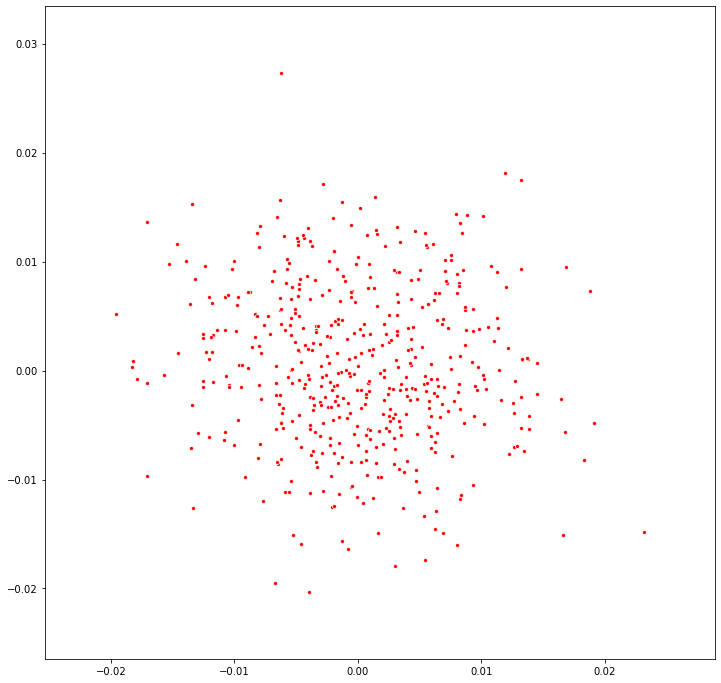

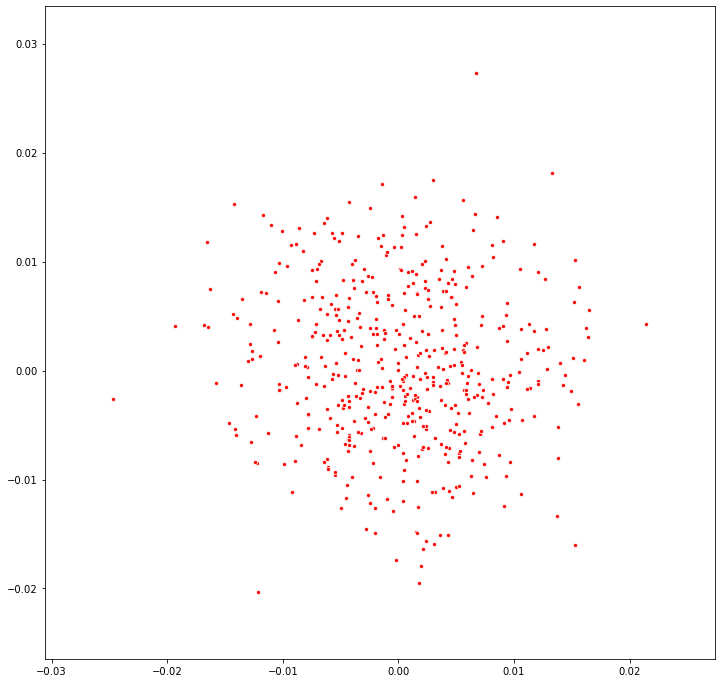

In [88]:
plt.figure(figsize = (12, 12))

def fast_scatter(
    data,
    N:     int = 100,
    i:     int = 0,
    j:     int = 0,
    fsize: tuple = (12, 12),
    s:     int = 16,
    col:   str = "red"):
    plt.figure(figsize = fsize)
    sns.scatterplot(
        x = hot_vectors_transformed[:500, i],
        y = hot_vectors_transformed[:500, j],
        s = 16,
        color = "red"
    )

# actually pretty similar for other pairs
fast_scatter(hot_vectors_transformed, 500, 1, 2)
fast_scatter(hot_vectors_transformed, 500, 0, 2)

In [89]:
# unfortunately, we can't use the princomp method for sparse matrices. so let's try singular decomposition
# about:
# https://en.wikipedia.org/wiki/Singular_value_decomposition
# https://arxiv.org/pdf/0909.4061.pdf

trunc_svd_model = TruncatedSVD(n_components = 8)

In [90]:
t_non = df_non_toxic.cleaned.str.join(' ')
t_ins = df_insulting.cleaned.str.join(' ')

pipeline_cleaned = Pipeline(
    [
        ('cnt-matr', CountVectorizer(vocabulary = cleaned_vocab)),
        ('tf-idf-sparse-matr', TfidfTransformer())
    ]
)

pipeline_n = pipeline_cleaned.fit(t_non)
pipeline_i = pipeline_cleaned.fit(t_ins)

non_toxic_edited = pipeline_n.transform(t_non)
insulting_edited = pipeline_i.transform(t_ins)

In [91]:
final_n = trunc_svd_model.fit_transform(non_toxic_edited)

print(
    trunc_svd_model.explained_variance_ratio_
)

final_i = trunc_svd_model.fit_transform(insulting_edited)

print(
    trunc_svd_model.explained_variance_ratio_
)

[0.00813266 0.00891359 0.00707747 0.00608977 0.00525308 0.00537523
 0.00449357 0.00452325]
[0.01492342 0.01658189 0.01241643 0.01202128 0.00864179 0.00856874
 0.00697811 0.00613385]


In [92]:
lim_n = 500

n, m = 4, 6

transformed_non_toxic = pd.DataFrame(final_n[:lim_n, (n,m)], columns = ['X', 'Y'])
transformed_insulting = pd.DataFrame(final_i[:lim_n, (n,m)], columns = ['X', 'Y'])

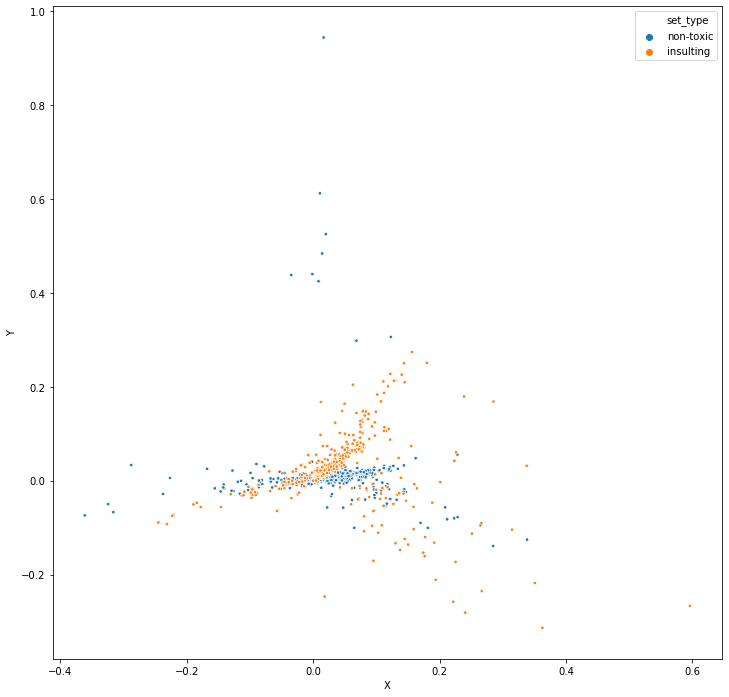

In [93]:
plt.figure(figsize = (12, 12))

sns.scatterplot(
    x = 'X',
    y = 'Y',
    data = pd.concat([transformed_non_toxic.assign(set_type='non-toxic'), transformed_insulting.assign(set_type='insulting')]),
    s = 12, hue = 'set_type'
)

Перші дві діаграми розсіювання зображені для проекції на площину векторизованих слів (точок у просторі) нещодавно утвореного словника методом головних компонент. Можна побачити, що дані формують кластер. Щільність точок пояснюється структурою початкових даних (j-те слово - вектор, на j-му місці стоїть 1, а на інших 0).

Остання діаграма - графічне зображення проекції точок, які репрезентують певні тексти, на площину. Координатами точки є значення міри tf-idf. Видно два кластери, які розташовані зовсім близько. Помаранчевим позначено дані з поміткою 'insulting' = 0, синім - 'non-toxic' = 1.

Варто відмітити, що отримані результати для обраних моделей (RandomForest, логістична регресія) будуть іншими у разі збільшення об'єму початкової вибірки.
На даних невеликого обсягу, регресія працює краще за алгоритм випадкового лісу,
однак на великих - навпаки.